# Craftmaker linear-programming problem

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def standard_form(A, c_T, EQ, x_T, prob):

    # sort equality constraints to last positions
    EQ_sorted = sorted(zip(EQ, A), key=lambda x: x[0] == 'E')

    # separate back
    EQ, A = zip(*EQ_sorted)
    A = np.array(A)

    # number of new slack/excess variables
    new = sum([eq != 'E' for eq in EQ])
    # number of equality constraints
    n_E = sum([eq == 'E' for eq in EQ])

    m = A.shape[0]      # number of constraints

    # add new columns for new variables
    A = np.hstack((A, np.zeros((m, new))))
    c_T = np.hstack((c_T, np.zeros(new)))
    
    n = A.shape[1]      # number of variables
    
    print("number of constraints: {}".format(m))
    print("number of variables: {}\n".format(n))

    # add new slack and excess variables
    for i, eq in enumerate(EQ):
        if eq == 'L':
            x_T.append(f'h{i+1}')
            A[i, n-m+n_E+i] = 1
        elif eq == 'G':
            x_T.append(f'e{i+1}')
            A[i, n-m+n_E+i] = -1

    print("extended A matrix:")
    print("{}\n".format(A))

    print("list of variables: {}\n".format(x_T))

    # convert to minimization, if needed
    if prob == 'max':
        c_T = -c_T

    return A, c_T, x_T

In [4]:
def simplex_iteration(A, b_T, c_T, x_T, col_B, col_N):

    # read size of A matrix
    m, n = A.shape

    # initialize reduced costs of non-basic variables
    cRed_N = -np.inf * np.ones(n-m)

    # flag for multiple optimum
    multiple = False

    # start SIMPLEX iterations
    while np.any(cRed_N <= np.finfo(float).eps):
        # restructure vectors and matrices
        x_T_B = [x_T[i] for i in col_B]
        x_T_N = [x_T[i] for i in col_N]
        c_T_B = c_T[col_B]
        c_T_N = c_T[col_N]
        B = A[:, col_B]
        B_inv = np.linalg.inv(B)
        N = A[:, col_N]

        # PHASE 1: initialization
        x_B = np.dot(B_inv, b_T)
        z = np.dot(c_T_B, x_B)
        
        print("basic variables")
        for i in range(m):
            print(f"{x_T_B[i]}: {x_B[i]:.3f}")
        
        print("\nnon-basic variables")
        for i in range(n-m):
            print(f"{x_T_N[i]}: 0.00")

        print("\nobjective function: {}".format(z))

        if np.any(x_B < -1e-6):
            print("\n>>> infeasible basis")
            break

        # PHASE 2: optimality check
        Y = np.dot(B_inv, N)
        
        print('\nmatrix Y:')
        for i in range(m):
            for j in range(n-m):
                print(f"{Y[i, j]:.3f} ", end="")
            print()

        cRed_N = c_T_N - np.dot(c_T_B, Y)
        
        print('\nreduced costs:')
        for i in range(n-m):
            print(f"{x_T_N[i]}: {cRed_N[i]:.3f}")
        
        # find entering variable, most negative reduced cost
        if np.any(cRed_N < 0):
            x_E = np.where(cRed_N == np.min(cRed_N))[0][0]
        # if any reduced cost is zero, potential multiple optima
        elif np.any(cRed_N == 0):
            if multiple:
                print("\n>>> multiple optima")
                break
            x_E = np.where(cRed_N == 0)[0][0]
            multiple = True
        # if all reduced costs are positive, optimal solution found
        elif np.all(cRed_N > np.finfo(float).eps):
            print("\n>>> optimal solution found")
            if np.any(x_B == 0):
                print("  ! degenerate solution")
            break
        
        print("\nentering variable: {}".format(x_T_N[x_E]))
        
        # PHASE 3: iteration
        if np.all(Y[:, x_E] <= 0):
            print("\n>>> unbounded solution")
            break

        y_x_E = Y[:, x_E]       # column of corresponding non-basic variable
        y_x_E[y_x_E == 0] = -1  # correct zeroes to avoid warnings

        exit_B = x_B / Y[:, x_E]
        exit_B[exit_B < 0] = np.inf
        x_L = np.where(exit_B == np.min(exit_B))[0][0]

        print("\nleaving variable: {}".format(x_T_B[x_L]))
        
        # PHASE 4: pivoting
        col_E = col_N[x_E]
        col_L = col_B[x_L]
        col_B[x_L] = col_E
        col_N[x_E] = col_L

        print("\n*************************************\n")

In [5]:
# this function only works when the two first columns correspond to X and Y
def plot_linear_program(A, b_T, c_T, EQ, x1_vals, x1_min, x1_max, x2_min, x2_max):

    plt.figure(figsize=(10, 10))

    # Plot each constraint
    for i in range(len(b_T)):
        if A[i, 1] != 0:
            x2_vals = (b_T[i] - A[i,0] * x1_vals) / A[i,1]

            plt.plot(x1_vals, x2_vals, 
                     label=f"Constraint {i+1}: {A[i, 0]}*x1 + {A[i, 1]}*x2 {'≤' if EQ[i] == 'L' else '≥' if EQ[i] == 'G' else '='} {b_T[i]}")

            if A[i,1] >= 0:
                if EQ[i] == 'L':
                    plt.fill_between(x1_vals, x2_min, x2_vals, color='gray', alpha=0.3)
                elif EQ[i] == 'G':
                    plt.fill_between(x1_vals, x2_vals, x2_max, color='gray', alpha=0.3)
            elif A[i,1] < 0:
                if EQ[i] == 'G':
                    plt.fill_between(x1_vals, x2_min, x2_vals, color='gray', alpha=0.3)
                elif EQ[i] == 'L':
                    plt.fill_between(x1_vals, x2_vals, x2_max, color='gray', alpha=0.3)
                
        else:
            plt.axvline(x=b_T[i] / A[i, 0], label=f"Constraint {i+1}: x2 {'='} {b_T[i] / A[i, 0]}", color='red')

    # Plot the objective function gradient
    step = 20
    max_axis = max(abs(x1_min), abs(x2_min), abs(x1_max), abs(x2_max))
    gradient_offsets = np.linspace(-step*max_axis, step*max_axis, step*20)

    if c_T[1] != 0:
        gradient_slope = -c_T[0] / c_T[1]
        for offset in gradient_offsets:
            plt.plot(x1_vals, gradient_slope * x1_vals + offset, '--', color='red', alpha=0.5, linewidth=0.5)
    else:
        for x in x1_vals:
            plt.axvline(x=x, color='red', linestyle='--', alpha=0.5, linewidth=0.5)

    # Plot settings
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()

### Problem: craftmaker

In [6]:
# problem type: 'min' or 'max'
prob = 'max'

# input data in matrix form
A = np.array([[10, 20],
              [15, 10],
              [18,  6]])

b_T = np.array([8000, 6000, 6300])

c_T = np.array([1.6, 1.4])

EQ = ['L', 'L', 'L']

x_T = ['x1', 'x2']

A, c_T, x_T = standard_form(A, c_T, EQ, x_T, prob)

number of constraints: 3
number of variables: 5

extended A matrix:
[[10. 20.  1.  0.  0.]
 [15. 10.  0.  1.  0.]
 [18.  6.  0.  0.  1.]]

list of variables: ['x1', 'x2', 'h1', 'h2', 'h3']



In [7]:
col_B = [2, 3, 4]
col_N = [0, 1]

simplex_iteration(A, b_T, c_T, x_T, col_B, col_N)

basic variables
h1: 8000.000
h2: 6000.000
h3: 6300.000

non-basic variables
x1: 0.00
x2: 0.00

objective function: 0.0

matrix Y:
10.000 20.000 
15.000 10.000 
18.000 6.000 

reduced costs:
x1: -1.600
x2: -1.400

entering variable: x1

leaving variable: h3

*************************************

basic variables
h1: 4500.000
h2: 750.000
x1: 350.000

non-basic variables
h3: 0.00
x2: 0.00

objective function: -560.0

matrix Y:
-0.556 16.667 
-0.833 5.000 
0.056 0.333 

reduced costs:
h3: 0.089
x2: -0.867

entering variable: x2

leaving variable: h2

*************************************

basic variables
h1: 2000.000
x2: 150.000
x1: 300.000

non-basic variables
h3: 0.00
h2: 0.00

objective function: -690.0000000000002

matrix Y:
2.222 -3.333 
-0.167 0.200 
0.111 -0.067 

reduced costs:
h3: -0.056
h2: 0.173

entering variable: h3

leaving variable: h1

*************************************

basic variables
h3: 900.000
x2: 300.000
x1: 200.000

non-basic variables
h1: 0.00
h2: 0.00

objective

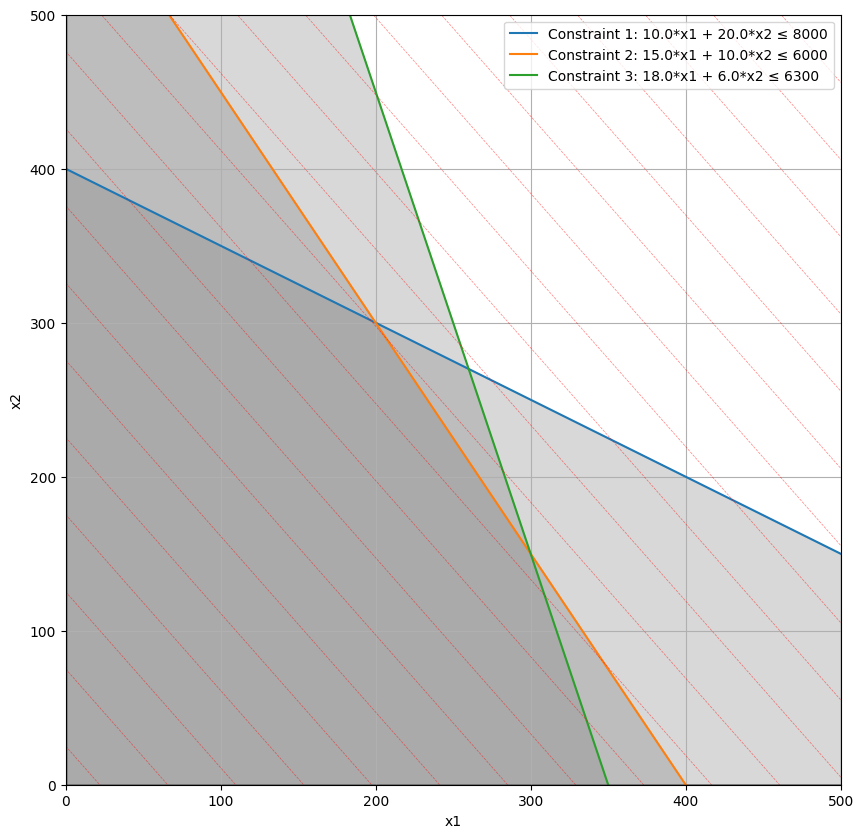

In [8]:
x1_vals = np.linspace(0, 500, 10)

plot_linear_program(A, b_T, c_T, EQ, x1_vals, 0, 500, 0, 500)